# **Preparation**

First, we mount the drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
# Tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
# Numpy and Pandas
import numpy as np
import pandas as pd
# Ohter import
import sys
#Images
from skimage.io import imread, imshow
from math import *

We manage to use .h5 files

In [3]:
!pip install -q pyyaml h5py

We check that we have access to the GPU

In [4]:
#' ' means CPU whereas '/device:G:0' means GPU
tf.test.gpu_device_name()

''

In [5]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=e181ced46886187fb8668e6171879e9e5e33920152e00c7b19f54da636434a18
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


IndexError: ignored

We import the dataset in the current memory

In [7]:
import zipfile
!unzip "/content/drive/MyDrive/DEEP LEARNING/compressed/dataset.zip"
print("Database unzipped")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_0.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_1.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_2.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_3.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_4.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_5.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_370_2_6.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_378_0_0.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_378_0_1.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_378_0_2.jpg  
  inflating: dataset/imagesVal/56--Voter/56_Voter_peoplevoting_56_378_1_0.jpg  
  inflating: dataset/imagesVal/56--Voter/5

#**MODEL TRAINING**

## Functions definitions

In [14]:
PATH_TO_DIRECTORY = "/content/"

PATH_TO_DATABASE = PATH_TO_DIRECTORY+"dataset/"

TRAIN_DIRECTORY = PATH_TO_DATABASE + "imagesTrain/"
TRAIN_TARGET_FILE = PATH_TO_DATABASE + "targets/targetsTrain.txt"

VAL_DIRECTORY = PATH_TO_DATABASE + "imagesVal/"
VAL_TARGET_FILE = PATH_TO_DATABASE + "targets/targetsVal.txt"

# We fix a limit for the train and val sets, because the memory is not big enough

TRAIN_IMAGES_LIMIT = 25000
VAL_IMAGES_LIMIT = 2500

#We set the ration between train and test sets, in order to take some train data as test data
RATIO_TRAIN_TEST = 9

# Shape of the input of the model
HEIGHT = 170
WIDTH = 256

# Compression factor of the mask compared to the pictures
COMPRESSION_FACTOR_MASK = 2

# Relative threshold on the number of pixels of faces on the picture
RELATIVE_THRESHOLD = 0

def getDataset():
  """
  Return trainDB, valDB, testDB
  """
  print("Loading train and test sets ("+str(RATIO_TRAIN_TEST)+" train for 1 test)...")
  trainDB, testDB = getTrainSet(TRAIN_DIRECTORY, TRAIN_TARGET_FILE, RATIO_TRAIN_TEST)
  print("Loading val set ...")
  valDB = getValSet(VAL_DIRECTORY, VAL_TARGET_FILE)
  print("Database loaded")
  return trainDB, valDB, testDB

def getLineTargetInfo(line):
  """
  Return the info of the line
  """
  res = line.split(' ')
  for i in range(len(res)-1,0,-1):
    if (len(res[i]) == 0):
      res.pop(i)
  return res

def createMask(boxes):
  """
  Create the mask from the corresponding boxes
  """
  res = np.zeros((HEIGHT, WIDTH))
  for b in boxes:
    res[b[1]:b[1]+b[3], b[0]:b[0]+b[2]] = 1
  return res

def getMaskDataset(boxesSet):
  """
  Get a mask dataset from the boxes set
  """
  maskDataset = []
  for boxes in boxesSet:
    maskDataset.append(createMask(boxes))
  return maskDataset


def getPictureSetFromNames(listOfNames):
  """
  Return the picture set from the list of picture names
  """
  imageList = []
  index = 0
  length = len(listOfNames)
  print("Number of datas : "+str(length))
  step = ceil(length/100)
  percent = 0
  print("0..", end = '')
  for path in listOfNames:
    index+=1
    if(index >= step):
      percent+=1
      index = 0
      print(str(percent)+"..", end = '')
    image = imread(PATH_TO_DIRECTORY+path)
    imageList.append(image)
  print("Pictures loaded")
  return imageList

def getTrainSet(imagesDirectory, targetFile, ratioTrainOnTest):
  """
  Get the train set of the dataset. It also give the test set
  """
  # We read the target file
  f = open(targetFile)
  lines = f.read().splitlines()
  f.close()

  dataset = []
  names = []
  targetsBoxes = []
  lineIndex = 0
  dataCounter = 0

  # We get a certain amount of data
  while ( lineIndex < len(lines) and (dataCounter < TRAIN_IMAGES_LIMIT or TRAIN_IMAGES_LIMIT < 0)):
    currentLine = lines[lineIndex]
    names.append(currentLine)
    lineIndex += 1
    currentLine = lines[lineIndex]
    numberOfBoxes = int(currentLine)
    boxes = []
    lineIndex +=1
    for i in range(numberOfBoxes):
      currentLine = lines[lineIndex]
      boxString = getLineTargetInfo(currentLine)
      box = list(map(int, boxString))
      boxes.append(box)
      lineIndex += 1
    targetsBoxes.append(boxes)
    dataCounter += 1
  # We convert the targets boxes as a masks set
  targets = getMaskDataset(targetsBoxes)

  #We filter these mask to only keep the ones with a certain amount of pixels with faces
  names, targets = eliminateNoFaces(names, targets, RELATIVE_THRESHOLD)

  # We compress the masks to fit with the model
  targets = compressMaskSet(targets, COMPRESSION_FACTOR_MASK)

  #We load all the pictures
  pictures = getPictureSetFromNames(names)

  dataset.append(pictures)
  dataset.append(names)
  dataset.append(targets)
  
  trainSet = []
  testSet = []

  trainPictures = []
  trainNames = []
  trainTargets = []

  testPictures = []
  testNames = []
  testTargets = []


  #We now distribute the data between the train and test sets
  counter = 0
  for i in range(len(dataset[0])):
    counter +=1
    if (counter % ratioTrainOnTest == 0):
      testPictures.append(dataset[0][i])
      testNames.append(dataset[1][i])
      testTargets.append(dataset[2][i])
      counter = 0
    else:
      trainPictures.append(dataset[0][i])
      trainNames.append(dataset[1][i])
      trainTargets.append(dataset[2][i])

  trainSet.append(np.array(trainPictures))
  trainSet.append(np.array(trainNames))
  trainSet.append(np.array(trainTargets))

  testSet.append(np.array(testPictures))
  testSet.append(np.array(testNames))
  testSet.append(np.array(testTargets))

  return trainSet, testSet

def getValSet(imagesDirectory, targetFile):
  """
  Get the value set of the dataset.
  """
  #Read the target file
  f = open(targetFile)
  lines = f.read().splitlines()
  f.close()

  dataset = []
  names = []
  targetsBoxes = []

  lineIndex = 0
  dataCounter = 0
  # We get a certain amount of data
  while ( lineIndex < len(lines) and (dataCounter < VAL_IMAGES_LIMIT or VAL_IMAGES_LIMIT < 0)):
    currentLine = lines[lineIndex]
    names.append(currentLine)
    lineIndex += 1
    currentLine = lines[lineIndex]
    numberOfBoxes = int(currentLine)
    boxes = []
    lineIndex +=1
    for i in range(numberOfBoxes):
      currentLine = lines[lineIndex]
      boxString = getLineTargetInfo(currentLine)
      box = list(map(int, boxString))
      boxes.append(box)
      lineIndex +=1
    targetsBoxes.append(boxes)
    dataCounter +=1

  # We convert the targets boxes as a masks set
  targets = getMaskDataset(targetsBoxes)

  #We filter these mask to only keep the ones with a certain amount of pixels with faces
  names, targets = eliminateNoFaces(names, targets, RELATIVE_THRESHOLD)

  # We compress the masks to fit with the model
  targets = compressMaskSet(targets, COMPRESSION_FACTOR_MASK)

  #We load all the pictures
  pictures = getPictureSetFromNames(names)

  dataset.append(np.array(pictures))
  dataset.append(np.array(names))
  dataset.append(np.array(targets))
  return dataset

def eliminateNoFaces(names, targets, relativeThreshold):
  """
  Eliminate the datas where there are not enough pixels of faces. Return the modified names and targets sets
  """
  shape = targets[0].shape
  threshold = shape[0]*shape[1]*relativeThreshold
  length = len(names)
  newNames = []
  newTargets = []
  for i in range(length):
    if (targets[i].sum() > threshold):
      newNames.append(names[i])
      newTargets.append(targets[i])
  return newNames, newTargets

def compressMaskSet(maskSet, factor):
  """
  Compress the masks in the mask set
  """
  if (factor == 1):
    return maskSet
  newSet = []
  print("Compressing targets ...")
  for mask in maskSet:
    newSet.append(compressMask(mask, factor))
  print("Targets compressed")
  return np.array(newSet)

def compressMask(mask, factor):
  """
  Compress a mask with the given factor
  """
  if (factor == 1):
    return mask
  newHeight = (int)(HEIGHT/factor)
  newWidth = (int)(WIDTH/factor)
  res = np.zeros((newHeight, newWidth))
  patch1 = mask[::factor, ::factor]
  patch2 = mask[1::factor, ::factor]
  patch3 = mask[::factor, 1::factor]
  patch4 = mask[1::factor, 1::factor]
  res = (patch1+patch2+patch3+patch4) > 0
  return res 


In [15]:
def getOriginalMask(mask, factor):
  """
  Get a mask in a higher resolution, in order to match the shape of the picture
  """
  if (factor == 1):
    return mask
  newHeight = mask.shape[0]*factor
  newWidth = mask.shape[1]*factor
  res = np.zeros((newHeight, newWidth))
  for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
      res[factor*y:factor*(y+1), factor*x:factor*(x+1)] = mask[y,x] 
  return res 



def merge(pic, mask, colorString = None, colorMask = None):
  """
  Merge a picture with its mask. The color of the mask on the picture can be chosen
  """
  if (colorMask == None):
    colorMask = [0,255,0]
    if (colorString == 'r'):
      colorMask = [255,0,0]
    elif (colorString == 'g'):
      colorMask = [0,255,0]

  #We get the mask in the same resolution as the picture
  mask = getOriginalMask(mask,COMPRESSION_FACTOR_MASK)
  #If one pixel is missing because of the division, we just readjust the shape
  if (mask.shape[0] < pic.shape[0]):
    tempMask = mask.copy()
    mask = np.zeros((pic.shape[0], mask.shape[1]))
    mask[:tempMask.shape[0], :tempMask.shape[1]] = tempMask
  if (mask.shape[1] < pic.shape[1]):
    tempMask = mask.copy()
    mask = np.zeros((mask.shape[0], pic.shape[1]))
    mask[:tempMask.shape[0], :tempMask.shape[1]] = tempMask
  res = pic.copy()
  mask = mask[:res.shape[0], :res.shape[1]]

  #We apply the mask
  opacity = 0.5
  for color in range(3):
    res[:,:,color] = np.clip(res[:,:,color]+mask*colorMask[color]*opacity,0,255)
  return res


## Load the dataset

In [16]:
dataset = getDataset()


Loading train and test sets (9 train for 1 test)...
Compressing targets ...
Targets compressed
Number of datas : 11205
0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..Pictures loaded
Loading val set ...
Compressing targets ...
Targets compressed
Number of datas : 1230
0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..Pictures loaded
Dat

### Check an exemple

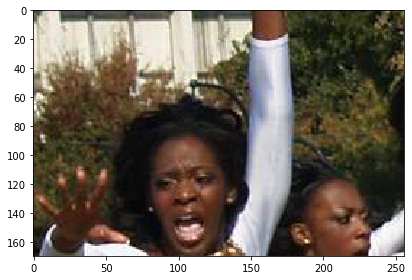

In [17]:
n = 50
imshow(dataset[0][0][n])

(85, 128)
(170, 256, 3)


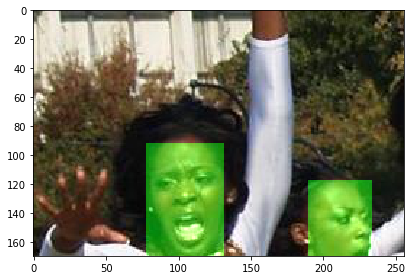

In [18]:

mask = dataset[0][2][n]
pic = dataset[0][0][n]
print(mask.shape)
print(pic.shape)
imshow(merge(pic, mask))


## **Model creation**

In [ ]:

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(HEIGHT, WIDTH, channelsNumber)))
model.add(layers.Activation(activations.relu))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation(activations.relu))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation(activations.relu))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), padding='same'))
model.add(layers.Activation(activations.relu))

model.add(layers.Conv2D(512, (3, 3), padding='same'))
model.add(layers.Activation(activations.relu))



model.add(layers.Conv2D(1, (1, 1), padding='same'))
model.add(layers.Activation(activations.sigmoid))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 170, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 170, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 170, 256, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 170, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 256, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 170, 256, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 128, 128)      0

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics= ['accuracy'])
print("Compiled")

Compiled


## **Load model**

In [ ]:
path_to_drive = "/content/drive/MyDrive/DEEP LEARNING/Models/" 

model = tf.keras.models.load_model(path_to_drive+'saveModel_v29.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 170, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 170, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 170, 256, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 170, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 170, 256, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 170, 256, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 128, 128)      0

## **Train model**

In [ ]:
trainValues, trainTargets = dataset[0][0], dataset[0][2]

valValues, valTargets = dataset[1][0], dataset[1][2]


history = model.fit(trainValues, trainTargets, epochs=25, validation_data=(valValues, valTargets))

Epoch 1/25


## **Automatic training**

In [ ]:
#To automatically train and save data

saveName = "/content/drive/MyDrive/DEEP LEARNING/Models/saveModel_v" 

actualCounter = 32

pathToModel = saveName+str(actualCounter)+".h5"

#We load the model
model = tf.keras.models.load_model(pathToModel)

model.summary()

dataset = getDataset()

trainValues, trainTargets = dataset[0][0], dataset[0][2]

valValues, valTargets = dataset[1][0], dataset[1][2]

fileName = "saveModel_v"
counter = actualCounter + 1

while (True):
  #We train our model for 10 epochs
  history = model.fit(trainValues, trainTargets, epochs=10, validation_data=(valValues, valTargets))
  #We save the model
  model.save(path_to_drive+fileName+str(counter)+".h5")
  counter += 1


## **Evaluate the model using the test dataset**

In [ ]:
testValues, testNames, testTargets = dataset[2]

test_loss, test_acc = model.evaluate(testValues,  testTargets, verbose=2)
print(test_loss)
print(test_acc)

39/39 - 18s - loss: 0.3631 - accuracy: 0.8664
0.36307817697525024
0.8663752675056458


In [21]:
testValues, testNames, testTargets = dataset[2]
print("Predicting ...")
length = 50
offset = 200
predictions = model.predict(testValues[offset:length+offset])
print("Predictions done")
for i in range(length):
  image = testValues[offset+i]
  prediction = predictions[i]
  predictionMask = prediction > 0.75
  target = testTargets[offset+i]
  plt.figure(figsize=(15,21))
  plt.subplot(1, 5, 1)
  plt.imshow(getOriginalMask(prediction,COMPRESSION_FACTOR_MASK))
  plt.clim(0,1)
  plt.subplot(1, 5, 2)
  plt.imshow(getOriginalMask(predictionMask,COMPRESSION_FACTOR_MASK))
  plt.clim(0,1)
  plt.subplot(1, 5, 3)
  plt.imshow(merge(image, predictionMask, colorString = 'g'))
  plt.subplot(1, 5, 4)
  plt.imshow(merge(image, detectFaces(image, model), colorString = 'g'))
  plt.subplot(1, 5, 5)
  plt.imshow(merge(image, target, colorString = 'r'))
  plt.show()




Output hidden; open in https://colab.research.google.com to view.

# **Application on different pictures**

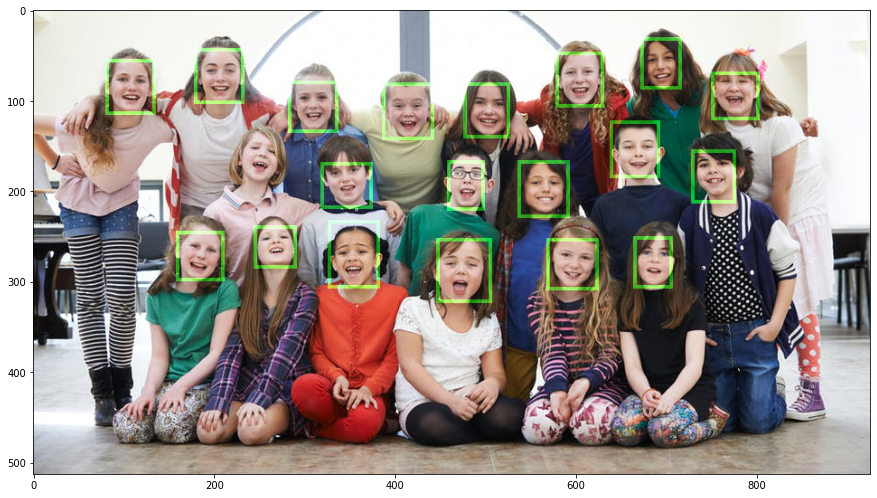

In [20]:
# Matplotlib
import matplotlib.pyplot as plt
# Tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
# Numpy and Pandas
import numpy as np
import pandas as pd
# Ohter import
import sys
#Images
from skimage.io import imread, imshow
from math import *

from skimage.morphology import disk, erosion, dilation

from scipy.ndimage import distance_transform_edt

from skimage.feature import peak_local_max
from skimage.measure import label

HEIGHT = 170
WIDTH = 256

COMPRESSION_FACTOR_MASK = 2

def getOriginalMask(mask, factor):
  """
  Get a mask in a higher resolution, in order to match the shape of the picture
  """
  if (factor == 1):
    return mask
  newHeight = mask.shape[0]*factor
  newWidth = mask.shape[1]*factor
  res = np.zeros((newHeight, newWidth))
  for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
      res[factor*y:factor*(y+1), factor*x:factor*(x+1)] = mask[y,x] 
  return res 



def merge(pic, mask, colorString = None, colorMask = None):
  """
  Merge a picture with its mask. The color of the mask on the picture can be chosen
  """
  if (colorMask == None):
    colorMask = [0,255,0]
    if (colorString == 'r'):
      colorMask = [255,0,0]
    elif (colorString == 'g'):
      colorMask = [0,255,0]

  #We get the mask in the same resolution as the picture
  mask = getOriginalMask(mask,COMPRESSION_FACTOR_MASK)
  #If one pixel is missing because of the division, we just readjust the shape
  if (mask.shape[0] < pic.shape[0]):
    tempMask = mask.copy()
    mask = np.zeros((pic.shape[0], mask.shape[1]))
    mask[:tempMask.shape[0], :tempMask.shape[1]] = tempMask
  if (mask.shape[1] < pic.shape[1]):
    tempMask = mask.copy()
    mask = np.zeros((mask.shape[0], pic.shape[1]))
    mask[:tempMask.shape[0], :tempMask.shape[1]] = tempMask
  res = pic.copy()
  mask = mask[:res.shape[0], :res.shape[1]]

  #We apply the mask
  opacity = 0.5
  for color in range(3):
    res[:,:,color] = np.clip(res[:,:,color]+mask*colorMask[color]*opacity,0,255)
  return res


def detectFaces(picture, model):
  """
  Return a mask with boxes which detects faces on a given picture of any resolution using the given model
  """
  subPictures =  []
  oldShape = (picture.shape[0], picture.shape[1])
  oldShape2 = oldShape
  newShape = (HEIGHT, WIDTH)
  move = (int(newShape[0]/4), int(newShape[1]/4))
  restriction = [False, False]

  #If the given picture is smaller than the input one for the model, we pad the picture with 0's
  if (oldShape[0] < newShape[0] and oldShape[1] < newShape[1]):
    subPicture = np.zeros((newShape[0], newShape[1], 3))
    subPicture[:oldShape[0], :oldShape[1]] = picture
    subPictures.append(subPicture)
    prediction = model.predict(np.array(subPictures))[0,:,:,0]
    #Once the prediction is done, we generate a mask from this
    mask = generateMaskFromPrediction(prediction)
    mask = mask[:oldShape[0], :oldShape[1]]
    return mask
  
  #If only one dimension is smaller than the input one for the model, we pad the picture to have the minimum size
  if (oldShape[0] < newShape[0]):
    tempPicture = picture.copy()
    picture = np.zeros((newShape[0], oldShape[1], 3))
    picture[:oldShape[0],:oldShape[1]] = tempPicture
    restriction[0] = True
    oldShape2 = (newShape[0], oldShape[1])
  elif (oldShape[1] < newShape[1]):
    tempPicture = picture.copy()
    picture = np.zeros((oldShape[0], newShape[1], 3))
    picture[:oldShape[0],:oldShape[1]] = tempPicture
    restriction[1] = True
    oldShape2 = (oldShape[0], newShape[1])

  # In order to work on every picture of any size, we will parse the picture by window of the size of the input for the model. 
  # To increase the accuracy of the predictions, we add some overlaps, in order to pass to the algorithm a same area multiple times
  for i in range(0, oldShape2[0]-newShape[0]+1, move[0]):
    for j in range(0, oldShape2[1]-newShape[1]+1, move[1]):
      subPicture = picture[i:i+newShape[0], j:j+newShape[1]]
      subPictures.append(subPicture)
  predictions = model.predict(np.array(subPictures))
  
  doneX = False
  doneY = False
  maskShape = (int(oldShape2[0]/COMPRESSION_FACTOR_MASK), int(oldShape2[1]/COMPRESSION_FACTOR_MASK))
  patchMaskShape = (int(newShape[0]/COMPRESSION_FACTOR_MASK), int(newShape[1]/COMPRESSION_FACTOR_MASK))
  moveMask = (int(move[0]/COMPRESSION_FACTOR_MASK), int(move[1]/COMPRESSION_FACTOR_MASK))
  filteredPrediction = np.zeros(maskShape)

  # We now try to reassemble the picture. We keep in memory how many times a pixel is given to the model, in order to take its mean value as the final value
  counterMask = np.zeros(maskShape)
  counter = 0
  for i in range(0, maskShape[0]-patchMaskShape[0]+1, moveMask[0]):
    #It could happen that the loop has never started. In this case, we have to be informed that we have to start it again
    doneX = True
    for j in range(0, maskShape[1]-patchMaskShape[1]+1, moveMask[1]):
      doneY = True
      counterMask[i:i+patchMaskShape[0], j:j+patchMaskShape[1]] += 1
      filteredPrediction[i:i+patchMaskShape[0], j:j+patchMaskShape[1]] += predictions[counter,:,:,0]
      counter += 1
  #We start the loop again for the only dimension which can be looped over
  if (not doneX):
    filteredPrediction = np.zeros(maskShape)
    counterMask = np.zeros(maskShape)
    counter = 0
    for j in range(0, maskShape[1]-patchMaskShape[1], moveMask[1]):
      counterMask[:, j:j+patchMaskShape[1]] += 1
      filteredPrediction[:, j:j+patchMaskShape[1]] += predictions[counter,:,:,0]
      counter += 1
  if (not doneY):
    filteredPrediction = np.zeros(maskShape)
    counterMask = np.zeros(maskShape)
    counter = 0
    for i in range(0, maskShape[0]-patchMaskShape[0], moveMask[0]):
      counterMask[i:i+patchMaskShape[0], :] += 1
      filteredPrediction[i:i+patchMaskShape[0], :] += predictions[counter,:,:,0]
      counter += 1

  #We take the mean value for the prediction of the whole picture
  counterMask[counterMask == 0] = 1
  filteredPrediction = np.divide(filteredPrediction, counterMask)

  #We now generate a mask from the given prediction
  mask = generateMaskFromPrediction(filteredPrediction)
  
  #If the mask had to be padded, we only take the area needed
  if (restriction[0]):
    mask = mask[:oldShape[0]//2,:]
  if (restriction[1]):
    mask = mask[:, :oldShape[1]//2]

  #If the mask give a result of 0 pixels selected, the resolution of the picture is maybe too high fir the model.
  #We then try to detect faces on a compressed version of the picture
  if (mask.sum() == 0):
    newPic = compressedPicture(picture)
    newMask = detectFaces(newPic, model)
    mask = getOriginalMask(newMask, 2)
  return mask

def compressedPicture(picture):
  """
  Return a compressed version of a given picture
  """
  subPic1 = picture[0:-1:2,0:-1:2]/4
  subPic2 = picture[0:-1:2,1::2]/4
  subPic3 = picture[1::2,0:-1:2]/4
  subPic4 = picture[1::2,1::2]/4
  return (subPic1+subPic2+subPic3+subPic4).astype(np.uint8)

def findBoxShape(mask):
  """
  Find the box and width of the box that includes all the pixels identifying a face in the mask
  """
  y, x = np.nonzero(mask > 0)
  width = max(max(x) - min(x),1)
  height = max(max(y) - min(y),1)

  return int(width), int(height)

def generateMaskBoxes(mask):
  """
  Generate a mask with boxes from a given mask with faces area
  """
  # We first try to find the center points of each faces
  dist = distance_transform_edt(mask)
  centerPoints = peak_local_max(dist, indices= False)

  # We identify each face as a separate object
  labels, n = label(mask, return_num=True)

  filteredMask = np.zeros(mask.shape)
  
  #We say that a face is identify if the box is big enough. It should have a minimal area
  minArea = (mask.shape[0]*mask.shape[1])/250

  # For every face, we try to generate a box
  for i in range(1, n+1):
    maskLabel = labels == i

    # We find the width and height of the box which can identify the face
    width, height = findBoxShape(maskLabel)

    # We define a thickness for the box
    thickness = int(max(min(width, height)/40, 2))

    # We find all the local maximums in the face 
    pointsInMask = np.zeros(mask.shape)
    pointsInMask[maskLabel == 1] = centerPoints[maskLabel == 1]

    # We now take these points and find the maximum one
    filteredDist = np.zeros(mask.shape)
    filteredDist[pointsInMask == 1] = dist[pointsInMask == 1]
    maxMask = peak_local_max(filteredDist, indices = False, num_peaks=1)

    # Now we define an element for the dilation as a rectangle of the given width and height
    elem = np.ones((height, width))

    #We define the inside of the box as a box of a reducted size
    insideElem = np.ones((max(height-2*thickness,1), max(width - 2*thickness,1)))

    #We generate the box
    faceMask = dilation(maxMask, elem)

    #If the face is not big enough, we don't consider it as a face
    if (faceMask.sum() < minArea):
      continue
    # We empty the inside of the box
    insideFaceMask = dilation(maxMask, insideElem)
    faceMask[insideFaceMask == 1] = 0
    filteredMask[faceMask == 1] = 1
  return filteredMask
def generateMaskFromPrediction(prediction):
  """
  Generate a mask from the given prediction. It applies some image transformations in order to get a mask with boxes
  """

  # We apply a certain threshold on the prediction
  mask1 = prediction > 0.85
  area = prediction.shape[0] * prediction.shape[1]
  
  # We will erode the mask in order to remove noise. The radius is relative to the area of the prediction
  radiusErosion = max(int(np.sqrt(area)/180), 1)
  mask2 = erosion(mask1, disk(radiusErosion))
  #Now, we dilate in order to have face areas big enough
  radiusDilation = int(radiusErosion*5)
  mask3 = dilation(mask2, disk(radiusDilation))
  # Finally, we generate the boxes
  mask4 = generateMaskBoxes(mask3)

  return mask4

pathToModel = "/content/drive/MyDrive/DEEP LEARNING/Models/saveModel_v29.h5"

model = tf.keras.models.load_model(pathToModel)

picture = imread("/content/test.jpg")
mask = detectFaces(picture, model)

plt.figure(figsize=(15,21))
plt.imshow(merge(picture, mask, colorString='g'))
plt.show()
